In [156]:
import numpy as np
import pandas as pd
import torch 
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

We create a dataset of harmonic sequences 

In [138]:
length_seq = 20
n_sample = 400

In [139]:
train_data = []
samplerate = length_seq
for i in range(n_sample):
  fs1 = np.random.randint(samplerate)
  fs2 = np.random.randint(samplerate)
  t = np.linspace(0., 1., samplerate)
  amplitude1 = np.iinfo(np.int16).max/10000
  amplitude2 = np.iinfo(np.int16).max/20000
  data1 = amplitude1 * np.sin(2. * np.pi * fs1 * t)
  data2 = amplitude2 * np.sin(2. * np.pi * fs2 * t)
  train_data.append(data1+data2)

In [140]:
train_data = np.array(train_data)

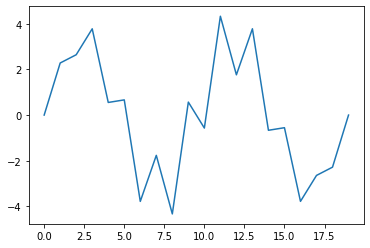

In [141]:
plt.plot(train_data[0])

In [142]:
#train_data = pd.DataFrame(np.transpose(train_data))
train_data = pd.DataFrame(train_data)

In [143]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data))

In [144]:
train_data_normalized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.732966,0.768888,0.889946,0.556991,0.567988,0.113912,0.319819,0.053565,0.561170,0.438830,0.946435,0.680181,0.886088,0.432012,0.443009,0.110054,0.231112,0.267034,0.696745
1,0.0,0.581078,0.758644,0.703614,0.930878,0.710292,0.946310,0.592930,0.820497,0.389147,0.610853,0.179503,0.407070,0.053690,0.289708,0.069122,0.296386,0.241356,0.418922,0.702062
2,0.0,0.507474,0.751355,0.004567,0.863915,0.447713,0.475456,0.468598,0.353700,0.955771,0.044229,0.646300,0.531402,0.524544,0.552287,0.136085,0.995433,0.248645,0.492526,0.313782
3,0.0,0.499249,0.710005,0.483009,0.870932,0.420585,0.933164,0.316737,0.903398,0.192269,0.807731,0.096602,0.683263,0.066836,0.579415,0.129068,0.516991,0.289995,0.500751,0.654206
4,0.0,0.785036,0.682793,0.977414,0.506096,0.547667,0.226392,0.112365,0.340029,0.227837,0.772163,0.659971,0.887635,0.773608,0.452333,0.493904,0.022586,0.317207,0.214964,0.702062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.608604,0.704094,0.783574,0.827216,0.833333,0.806304,0.746082,0.657636,0.558119,0.441881,0.342364,0.253918,0.193696,0.166667,0.172784,0.216426,0.295906,0.391396,0.755237
396,0.0,0.936053,0.605273,0.330413,0.689927,0.778778,0.217766,0.053321,0.563449,0.696736,0.303264,0.436551,0.946679,0.782234,0.221222,0.310073,0.669587,0.394727,0.063947,0.702062
397,0.0,0.415047,0.234765,0.634551,0.416846,0.908202,0.274290,0.703584,0.004567,0.759550,0.240450,0.995433,0.296416,0.725710,0.091798,0.583154,0.365449,0.765235,0.584953,0.585079
398,0.0,0.500000,0.497717,0.502283,0.500000,0.500000,0.500000,0.500000,0.497717,0.502305,0.497695,0.502283,0.500000,0.500000,0.500000,0.500000,0.497717,0.502283,0.500000,0.510581


In [145]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [146]:
train_dataset, seq_len, n_features = create_dataset(train_data_normalized)

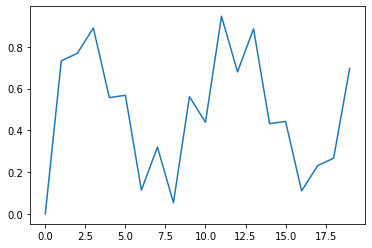

In [147]:
plt.plot(train_dataset[0])

## Encoder

In [148]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim = 64, latent_dim = 10):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.latent_dim = latent_dim

    self.rnn1 = nn.LSTM(
      input_size = n_features,         # 1
      hidden_size = self.hidden_dim,   # 128
      num_layers = 1,
      batch_first = True
    )
    
    self.rnn2 = nn.LSTM(
      input_size = self.hidden_dim,    # 128
      hidden_size = embedding_dim,     # 64
      num_layers = 1,
      batch_first = True
    )

    self.l1 = nn.Linear(embedding_dim, 2 * latent_dim)  # 64x20
    self.mu = nn.Linear(2 * latent_dim, latent_dim)     # 20x10
    self.logvar = nn.Linear(2 * latent_dim, latent_dim) # 20x10

  def sample(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    hidden_n = torch.tanh(self.l1(hidden_n))
    mu = self.mu(hidden_n).reshape(((self.n_features, self.latent_dim)))
    logvar = self.logvar(hidden_n).reshape(((self.n_features, self.latent_dim)))

    sample = self.sample(mu, logvar)

    return self.sample(mu, logvar), mu, logvar

# Decoder

In [158]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim = 10, n_features = 1, embedding_dim = 64):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size = input_dim,
      hidden_size = input_dim,
      num_layers = 1,
      batch_first = True
    )

    self.rnn2 = nn.LSTM(
      input_size = input_dim,
      hidden_size = self.hidden_dim,
      num_layers = 1,
      batch_first = True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return  torch.sigmoid(self.output_layer(x))

In [159]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar, beta = 1., loss = nn.BCEWithLogitsLoss(reduction = 'sum')):
    """
    Check https://arxiv.org/abs/1312.6114 appendix
    """
    likelihood = F.binary_cross_entropy(x_hat, x, reduction = 'sum')
    #likelihood = loss(x_hat, x)
    div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return likelihood + beta * div

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [161]:
embedding_dim = 60
latent_dim = 20
encoder = Encoder(seq_len, n_features, embedding_dim, latent_dim).to(device)
decoder = Decoder(seq_len, latent_dim, n_features, embedding_dim).to(device)

In [162]:
def train_model(encoder, decoder, train_dataset, n_epochs, lr = 1e-3, print_step = False):
  history = []

  params = list(encoder.parameters()) + list(decoder.parameters())
  optimizer = optim.Adam(params, lr = lr)
  
  for epoch in range(1, n_epochs + 1):
    encoder = encoder.train()
    decoder = decoder.train()

    train_losses = []
    i = 0
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      out_enc, mu, logvar = encoder(seq_true)
      seq_pred = decoder(out_enc)

      loss = loss_function(seq_pred[:10], seq_true[:10], mu, logvar)
  
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
      if i % 100 == 0 and print_step:
        print(i)
      i += 1
    train_loss = np.mean(train_losses)
    history.append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return history, encoder, decoder

In [163]:
hist, encoder, decoder = train_model(encoder, decoder, train_dataset, 50, lr = 1e-3, print_step = True)

0
100
200
300
Epoch 1: train loss 6.651234451532364
0
100
200
300
Epoch 2: train loss 6.300555794239044
0
100
200
300
Epoch 3: train loss 6.261681362390518
0
100
200
300
Epoch 4: train loss 6.255232938528061
0
100
200
300
Epoch 5: train loss 6.252330669164658
0
100
200
300
Epoch 6: train loss 6.247820914983749
0
100
200
300
Epoch 7: train loss 6.246786662340164
0
100
200
300
Epoch 8: train loss 6.247222093343734
0
100
200
300
Epoch 9: train loss 6.245663064718246
0
100
200
300
Epoch 10: train loss 6.245228244066238
0
100
200
300
Epoch 11: train loss 6.244844045639038
0
100
200
300
Epoch 12: train loss 6.2450975477695465
0
100
200
300
Epoch 13: train loss 6.244710993766785
0
100
200
300
Epoch 14: train loss 6.2439688467979435
0
100
200
300
Epoch 15: train loss 6.242931152582169
0
100
200
300
Epoch 16: train loss 6.243306146860123
0
100
200
300
Epoch 17: train loss 6.243130196332931
0
100
200
300
Epoch 18: train loss 6.242672054767609
0
100
200
300
Epoch 19: train loss 6.242892105579376


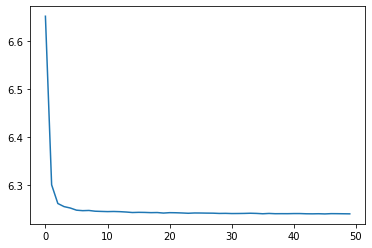

In [164]:
plt.plot(hist)

In [ ]:
MODEL_PATH_ENC = 'encoder.pth'
MODEL_PATH_DEC = 'encoder.pth'

torch.save(encoder, MODEL_PATH_ENC)
torch.save(decoder, MODEL_PATH_DEC)